# Первый запуск

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk

from math import log10, log
from random import shuffle

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import cross_val_score

In [4]:
df = pd.read_csv('adult.csv')

In [5]:
def find_numer_cols(df, exept = []):
    numerical_mask = [np.issubdtype(df[name].dtype, np.number) and not name in exept for name in df.columns]
    return df.columns[numerical_mask]

numerical_columns = find_numer_cols(df)
print(numerical_columns)

Index(['age', 'fnlwgt', 'education.num', 'capital.gain', 'capital.loss',
       'hours.per.week'],
      dtype='object')


In [6]:
def create_dict(names, val = 0):
    to_ret = {}
    for i in names:
        to_ret[i] = val
    return to_ret

# Перобразования входных данных

## Обработка счетчиков

### Разбиение фиксированной ширины

### Квантильное разбиение

<AxesSubplot: >

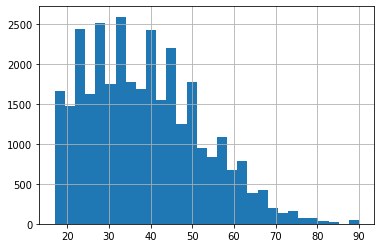

In [7]:
df['age'].hist(bins=30)

[14 12  8  6  7 10  5 13  1  4 11  9  2  3  0]


0.066667    20.0
0.133333    23.0
0.200000    26.0
0.266667    28.0
0.333333    31.0
0.400000    33.0
0.466667    36.0
0.533333    38.0
0.600000    41.0
0.666667    44.0
0.733333    47.0
0.800000    50.0
0.866667    55.0
0.933333    61.0
Name: age, dtype: float64

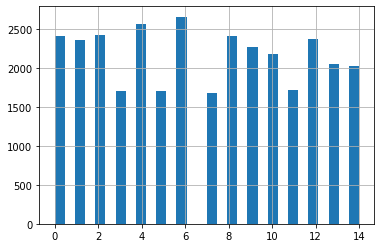

In [8]:
# Применяет квантильное разделение к столбцу
output_par = pd.qcut(df['age'], 15, labels = False)

print(output_par.unique())
output_par.hist(bins=30)

# Возвращает значение квантелей
df['age'].quantile([x/15 for x in range(1, 15)])

### Логарифмическое преобразование

<AxesSubplot: >

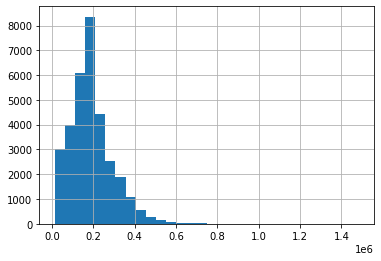

In [9]:
df['fnlwgt'].hist(bins=30)

<AxesSubplot: >

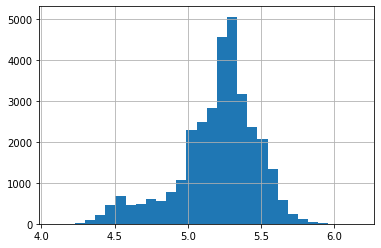

In [10]:
df['fnlwgt'].apply(lambda x: log10(x)).hist(bins=30)

### Логарифмическое преобразование в действии

In [11]:
sk_lsm = sk.linear_model.LinearRegression()

In [12]:
cross_val_score(sk_lsm,  df[['fnlwgt']], df['capital.gain']).mean()

-0.023271968056456194

In [13]:
df['LogFnlwgt'] = df['fnlwgt'].apply(lambda x: log10(x))
cross_val_score(sk_lsm,  df[['LogFnlwgt']], df['capital.gain']).mean()

-0.023271968056456194

### Преобразование Бокса-Кокса

In [63]:
def box_cox(x, lam):
    if(lam == 0):
        return log(x)
    return (x**lam - 1)/lam

## Маштабирование признаков или нормализация

### Масштабирование по минимаксу

In [14]:
class min_max:
    
    def tr(self, df):
        self.min = {}
        self.range = {}
        to_ret = df[:]
        for col in df.columns:
            self.min[col] = df[col].min()
            self.range[col] = df[col].max() - self.min[col]
            to_ret[col] -= self.min[col]
            to_ret[col] /= self.range[col]
        return to_ret
    
    def inv(self, df):
        to_ret = df[:]
        for col in self.min.keys():            
            to_ret[col] = to_ret[col]*self.range[col] + self.min[col]
        return to_ret

<AxesSubplot: >

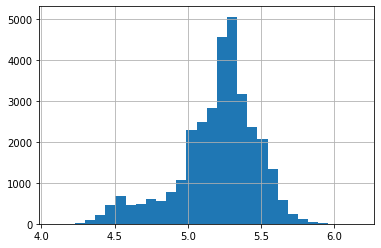

In [20]:
df['LogFnlwgt'].hist(bins = 30)

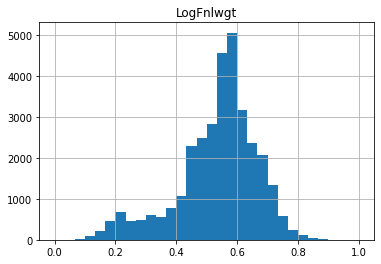

In [21]:
mnmx = min_max()
temp = mnmx.tr(df[[ 'LogFnlwgt']]).hist(bins = 30)

### Стандартизация(масштабирование дисперсии)

In [22]:
class mean_std:
    
    def tr(self, df):
        self.mean = {}
        self.std = {}
        to_ret = df[:]
        for col in df.columns:
            self.mean[col] = df[col].mean()
            self.std[col] = df[col].std()
            to_ret[col] -= self.mean[col]
            to_ret[col] /= self.std[col]
        return to_ret
    
    def inv(self, df):
        to_ret = df[:]
        for col in self.mean.keys():            
            to_ret[col] = to_ret[col]*self.std[col] + self.mean[col]
        return to_ret

<AxesSubplot: >

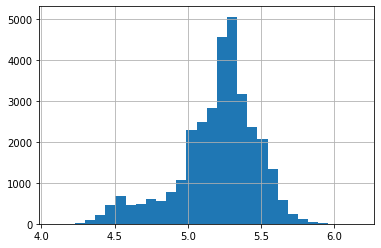

In [23]:
df['LogFnlwgt'].hist(bins = 30)

array([[<AxesSubplot: title={'center': 'LogFnlwgt'}>]], dtype=object)

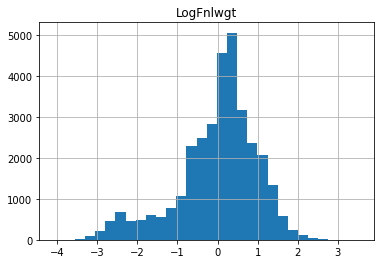

In [25]:
mnstd = mean_std()
mnstd.tr(df[[ 'LogFnlwgt']]).hist(bins = 30)

### Нормализация l^2

In [26]:
class l2:
    
    def tr(self, df):
        self.euc = {}
        to_ret = df[:]
        for col in df.columns:
            self.euc[col] = sum(df[col]**2)**(0.5)
            to_ret[col] /= self.euc[col]
        return to_ret
    
    def inv(self, df):
        to_ret = df[:]
        for col in self.euc.keys():            
            to_ret[col] *= self.euc[col]
        return to_ret

<AxesSubplot: >

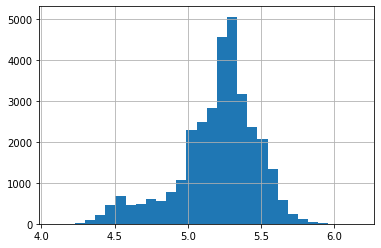

In [27]:
df['LogFnlwgt'].hist(bins = 30)

array([[<AxesSubplot: title={'center': 'LogFnlwgt'}>]], dtype=object)

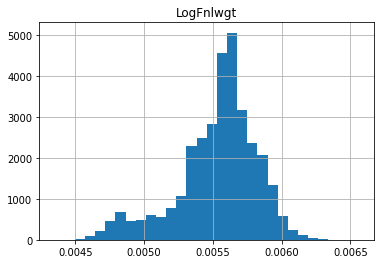

In [28]:
l2_norm = l2()
l2_norm.tr(df[[ 'LogFnlwgt']]).hist(bins = 30)

## Взаимодействие признаков

In [169]:
num_col = find_numer_cols(df, ['LogLotArea', 'SalePrice'])
nan_mask = list(df[num_col].isna().sum() == 0)
num_col = num_col[nan_mask]
y = df[['SalePrice']]

In [163]:
df1 = df[num_col]
df1.shape

(1460, 34)

In [168]:
# interaction_only = True- исключает вторые степени фичей
df2 = sk.preprocessing.PolynomialFeatures(interaction_only = True, include_bias = False).fit_transform(df1)
df2.shape

(1460, 595)

In [170]:
x1_train, x1_test, x2_train, x2_test, y_train, y_test = train_test_split(df1, df2, y, test_size = 0.3, random_state = 42)

In [182]:
lsm1 = linear_model.LinearRegression().fit(x1_train, y_train)
lsm2 = linear_model.LinearRegression().fit(x2_train, y_train)

print('x1', mse(y_test, lsm1.predict(x1_test)))
print('x2', mse(y_test, lsm2.predict(x2_test)))

x1 1281871520.8770552
x2 3.090109810935875e+25


## Отбор признаков

### Фильтрация

### Метод обертывания

### Встроеные методы

# Текстовые данные: выравнивание, фильтрация, разбиение

## Множество слов 

In [5]:
text = 'it is a puppy and it is extremely cute'
word_of_set = [
    'it',
    'they',
    'puppy',
    'and',
    'cat',
    'cute',
    'extremely'
]

In [6]:
def fill_dict(wd, text):
    for i in text:
        if i in wd.keys():
            wd[i] += 1

In [7]:
word_dict = create_dict(word_of_set)
fill_dict(word_dict, text.split(' '))
word_dict

{'it': 2, 'they': 0, 'puppy': 1, 'and': 1, 'cat': 0, 'cute': 1, 'extremely': 1}

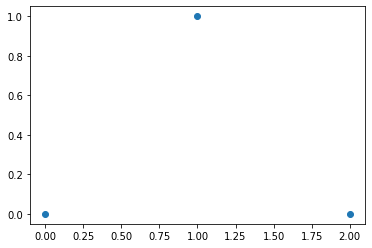

In [8]:
text1 = 'it is cute puppy and cute cat'
text2 = 'it is cute puppy and ugly cat'
text3 = 'it is terrible'

word_dict1 = create_dict(['cute', 'ugly'])
word_dict2 = create_dict(['cute', 'ugly'])
word_dict3 = create_dict(['cute', 'ugly'])

fill_dict(word_dict1, text1.split(' '))
fill_dict(word_dict2, text2.split(' '))
fill_dict(word_dict3, text3.split(' '))

x = [word_dict1['cute'], word_dict2['cute'], word_dict3['cute']]
y = [word_dict1['ugly'], word_dict2['ugly'], word_dict3['ugly']]

plt.scatter(x,y)